# DPO
Direct Preference Optimization \
是一种用于有监督指令微调后模型偏好对齐的训练方法，目标是让模型更倾向于输出人类偏好的回答（chosen），而不是次优回答（rejected）

## 查看DPO训练数据集格式

In [1]:
import json
pretrain_dataset_path = r"D:\MiniMind\dataset\dpo.jsonl"
with open(pretrain_dataset_path, "r", encoding="utf-8") as f:
    for line_num, line in enumerate(f, 1):
        data = json.loads(line.strip())
        break

print(data.keys())
print(data)

dict_keys(['chosen', 'rejected'])
{'chosen': [{'content': 'continue', 'role': 'user'}, {'content': 'As Recharge Retreats grows, we plan to expand our team with additional event coordinators and marketing specialists. To accommodate this growth, we will establish an office space that fosters collaboration and creativity among team members. We will also prioritize remote work options and streamlined communication tools to support remote team members.\n\nIn addition, we aim to diversify our retreat offerings to cater to different themes, such as solo travel retreats, wellness retreats for parents, and spiritual journeys. We will seek to partner with multiple venues across various locations worldwide to provide a diverse range of retreat experiences.\n\nWe will also expand our marketing efforts to reach a wider audience, maximizing brand exposure through influencer partnerships, experiential marketing, and virtual events. We will continuously strive to refine our services based on client f

## 准备DPO训练数据加载器

In [4]:
import json
import torch
from torch.utils.data import Dataset

class DPODataset(Dataset):
    def __init__(self, file_path, tokenizer, max_length=4096):
        super().__init__()
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.padding = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0 # 填充的token id

        # 特殊标记（开头和结尾的边界符）
        # input_ids表示分词后得到的token id序列
        self.bos_id = tokenizer('<|im_start|>assistant', add_special_tokens=False).input_ids
        self.eos_id = tokenizer('<im_end>', add_special_tokens=False).input_ids

        # 加载JSONL格式数据：每行为一个dict，有chosen和rejected
        with open(file_path, 'r', encoding='utf-8') as f:
            self.data = []
            for line in f:
                line = line.strip()
                # json.load(f)是读取一个完整的json对象 [{...}, {...}]
                # json.loads(f)是解析一段json字符串
                obj = json.loads(line) 
                self.data.append(obj)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        item = self.data[index]

        chosen = item['chosen']
        rejected = item['rejected']

        # 拼接成字符串
        chosen_prompt = self.tokenizer.apply_chat_template(
            chosen, tokenize=False, add_generation_prompt=False
        )
        rejected_prompt = self.tokenizer.apply_chat_template(
            rejected, tokenize=False, add_generation_prompt=False
        )

        # 编码为input_ids（截断+填充）
        chosen_encoding = self.tokenizer(
            chosen_prompt,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
        )
        rejected_encoding = self.tokenizer(
            rejected_prompt,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
        )

        # 转换为token ID列表，长度为max_length
        chosen_input_ids = chosen_encoding["input_ids"]
        rejected_input_ids = rejected_encoding["input_ids"]

        # 构造loss mask:仅在 assistant 段落（<|im_start|>assistant ... <|im_end|>）中的 token 参与损失
        chosen_loss_mask = self._generate_loss_mask(chosen_input_ids)
        rejected_loss_mask = self._generate_loss_mask(rejected_input_ids)

        # 构造训练数据
        x_chosen = torch.tensor(chosen_input_ids[:-1], dtype=torch.long)
        y_chosen = torch.tensor(chosen_input_ids[1:], dtype=torch.long)
        mask_chosen = torch.tensor(chosen_loss_mask[1:], dtype=torch.long)

        x_rejected = torch.tensor(rejected_input_ids[:-1], dtype=torch.long)
        y_rejected = torch.tensor(rejected_input_ids[1:], dtype=torch.long)
        mask_rejected = torch.tensor(rejected_loss_mask[1:], dtype=torch.long)

        return {
            "x_chosen": x_chosen,
            "y_chosen": y_chosen,
            "mask_chosen": mask_chosen,

            "x_rejected": x_rejected,
            "y_rejected": y_rejected,
            "mask_rejected": mask_rejected,
        }
    def _generate_loss_mask(self, input_ids):
        # 根据<im_sytart>assistant和<im_end>的位置标记哪些token应该参与损失计算
        # 返回一个和input_ids等长的0/1 mask
        loss_mask = [0] * len(input_ids)
        i = 0
        while i < len(input_ids):
            # 匹配一个assistant段落开头
            if input_ids[i: i+len(self.bos_id)] == self.bos_id:
                start = i + len(self.bos_id)
                end = start
                while end < len(input_ids):
                    # 查找assistant的结束符<im_end>
                    if input_ids[end: end+len(self.eos_id)] == self.eos_id:
                        break
                    end += 1
                # 在<im_start>assistant和<im_end>之间部分启用loss
                for j in range(start+1, min(end+len(self.eos_id)+1, self.max_length)):
                    loss_mask[j] = 1
                i = end + len(self.eos_id) if end < len(input_ids) else len(input_ids)
            else:
                i += 1
        return loss_mask

## DPO损失函数

DPO的目标是让训练后的模型更偏好chosen答案，而不是rejected答案，这种偏好是在对比参考模型reference model的基础上学来的 \
参考模型指的是做了预训练或SFT之后的模型 \
DPO核心在于用了一个直接可微的损失函数，来优化模型对人类偏好的响应，不需要训练单独的奖励模型或复杂的强化学习方法 \ 
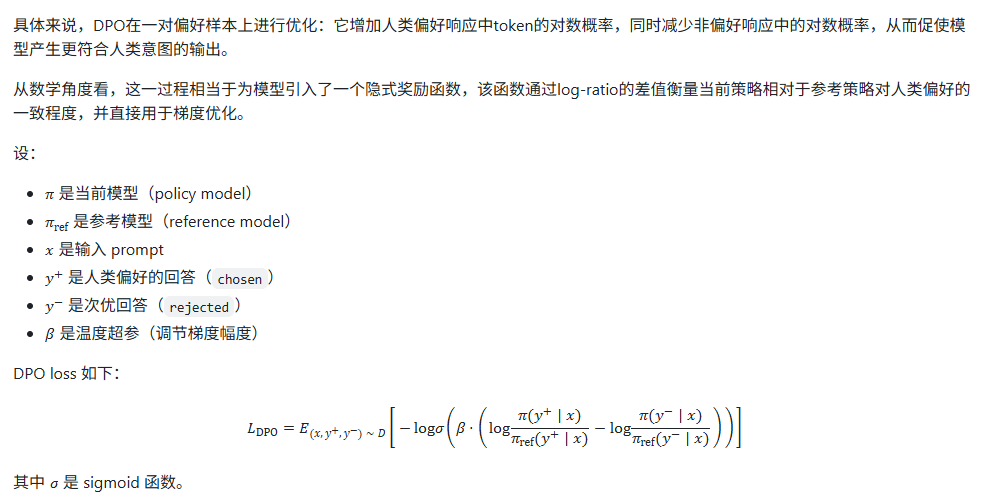


$ \mathcal{L}{\text{DPO}} = \mathbb{E}{(x, y^+, y^-) \sim \mathcal{D}} \left[ -\log \sigma \left( \beta \cdot \left( \log \frac{\pi(y^+|x)}{\pi(y^-|x)} - \log \frac{\pi_{\text{ref}}(y^+|x)}{\pi_{\text{ref}}(y^-|x)} \right) \right) \right] $

DPO Loss实际是对整个数据分布的平均损失 \
policy model是已经做过pretrained/SFT的模型，且参数可优化，但是reference model参数是固定的 \
理论上DPO是全量参数微调，但工程中是部分参数微调 \

In [8]:
import torch.nn.functional as F

def dpo_loss(ref_probs, probs, mask, beta):
    # ref_probs: (batch_size, seq_len) reference model的log_probs
    # probs: (batch_size, seq_len) policy model的log_probs
    # mask: (batch_size, seq_len) 标记哪些token被计入损失
    # beta: float 超参数控制分布偏移强度

    # Step 1: 每个样本的有效长度
    # 注意非padding的token是1，padding的token是0
    seq_lengths = mask.sum(dim=1, keepdim=True) # (batch_size, 1)

    # Step 2：对每个样本计算平均log-probs，仅在mask==1的位置有效
    ref_probs = (ref_probs * mask).sum(dim=1) / seq_lengths.squeeze(1) # (batch_size,)
    probs = (probs * mask).sum(dim=1) / seq_lengths.squeeze(1)

    # Step 3: 将batch划分为前一半为chosen，后一半为rejected
    batch_size = ref_probs.shape[0]

    chosen_ref_probs = ref_probs[:batch_size // 2]
    reject_ref_probs = ref_probs[batch_size // 2:]
    chosen_probs = probs[:batch_size // 2]
    reject_probs = probs[batch_size // 2:]

    # Step 4: log-ratio比较
    pi_logratios = chosen_probs - reject_probs
    ref_logratios = chosen_ref_probs - reject_ref_probs

    # Step 5: 计算DPO loss
    logits = pi_logratios - ref_logratios
    loss = -F.logsigmoid(beta * logits)

    return loss.mean()

## 开始训练DPO

In [ ]:
for step, batch in enumerate(train_loader):
    x_chosen = batch['x_chosen'].to(args.device)
    x_rejected = batch['x_rejected'].to(args.device)

    # 标签 token ids
    y_chosen = batch['y_chosen'].to(args.device)
    y_rejected = batch['y_rejected'].to(args.device)

    # 哪些位置计算loss
    mask_chosen = batch['mask_chosen'].to(args.device)
    mask_rejected = batch['mask_rejected'].to(args.device)

    # 拼接成整体batch
    x = torch.cat([x_chosen, x_rejected], dim=0)
    y = torch.cat([y_chosen, y_rejected], dim=0)
    mask = torch.cat([mask_chosen, mask_rejected], dim=0)

    # 设置学习率
    lr = get_lr(epoch * iter_per_epoch + step, args.epochs * iter_per_epoch, args.learning_rate)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    with ctx:
        with torch.no_grad():
            ref_outputs = ref_model(x)
            ref_logits = ref_outputs.logits

        # 参考模型的log prob，对应标签token的概率
        ref_probs = logits_to_probs(ref_logits, y)
        ref_probs = ref_probs * mask

        # 当前模型 logits
        outputs = model(x)
        logits = outputs.logits

        # 当前模型的token-level log prob
        
